In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
import re
import string


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [4]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Step1：資料預處理 

In [5]:
#移除符號
df['Review'] = df['Review'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x))  

In [6]:
#移除stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snoza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df['Review'] = df['Review'].apply(lambda x: remove_stopwords(x))

In [8]:
def generate_len(df):
    df['review_len'] = df['Review']
    for index, row in df.iterrows():
        df['review_len'].iloc[index] = len(df['Review'].iloc[index])
    
    return df
    

In [9]:
df = generate_len(df)

C:\Users\snoza\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
df['review_len'].astype('int32').describe()

count    20491.000000
mean       689.261139
std        651.461792
min         36.000000
25%        323.000000
50%        511.000000
75%        820.500000
max      12948.000000
Name: review_len, dtype: float64

In [11]:
#820字的長度已經能涵蓋75%評論，為防止補過多0造成訓練緩慢，Truncate所有字在1000字以下
df['Review'] = df['Review'].str.slice(0, 1000)

In [12]:
#重新算一次評論字數分布
df = generate_len(df)
df['review_len'].astype('int32').describe()

count    20491.000000
mean       564.190083
std        285.297735
min         36.000000
25%        323.000000
50%        511.000000
75%        820.500000
max       1000.000000
Name: review_len, dtype: float64

In [13]:
df['Rating'] = df['Rating'].apply(lambda x: 2 if x > 3 else (1 if x == 3 else 0))

In [14]:
X = np.asarray(df['Review'])
Y = np.asarray(df['Rating'],  dtype=int)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.3)

## Step2：讀取glova.6B.50d，遷移學習詞向量 

In [17]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [18]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [19]:
word = "charge"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of charge in the vocabulary is 97097
the 289846th word in the vocabulary is potatos


In [20]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index.keys():
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j + 1
            
    ### END CODE HERE ###
    
    return X_indices

In [22]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = emb_dim, trainable = False )
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [23]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.39031
Input_dim 400001
Output_dim 50


## Step3：設定模型架構 

In [24]:
def review_model(input_shape, word_to_vec_map, word_to_index):
    """
    
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 32, return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.2)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units = 32 , return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate = 0.2)(X)
    # Propagate X through a Dense layer with 3 units
    X = Dense(units = 3)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [ ]:
#設定評論字數，決定序列長度
maxLen = 1000

In [25]:
model = review_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1000, 50)          20000050  
                                                                 
 lstm (LSTM)                 (None, 1000, 32)          10624     
                                                                 
 dropout (Dropout)           (None, 1000, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99    

In [26]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Step4：模型訓練

In [ ]:
#將評分轉為one hot
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y-1]
    return Y

In [27]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 3)

In [28]:
#設定GPU、CPU提升效能
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [56]:
model.fit(X_train_indices, Y_train_oh, epochs = 5, batch_size = 32, shuffle=True)

Epoch 1/5
449/449 [==============================] - 198s 437ms/step - loss: 0.7667 - accuracy: 0.7335
Epoch 2/5
449/449 [==============================] - 246s 548ms/step - loss: 0.7606 - accuracy: 0.7352
Epoch 3/5
449/449 [==============================] - 297s 663ms/step - loss: 0.7600 - accuracy: 0.7352
Epoch 4/5
449/449 [==============================] - 389s 867ms/step - loss: 0.7595 - accuracy: 0.7352
Epoch 5/5
449/449 [==============================] - 418s 932ms/step - loss: 0.7587 - accuracy: 0.7352


## Step5：模型準確度測試 

In [58]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 3)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

193/193 [==============================] - 68s 348ms/step - loss: 0.7491 - accuracy: 0.7398

Test accuracy =  0.7397527694702148


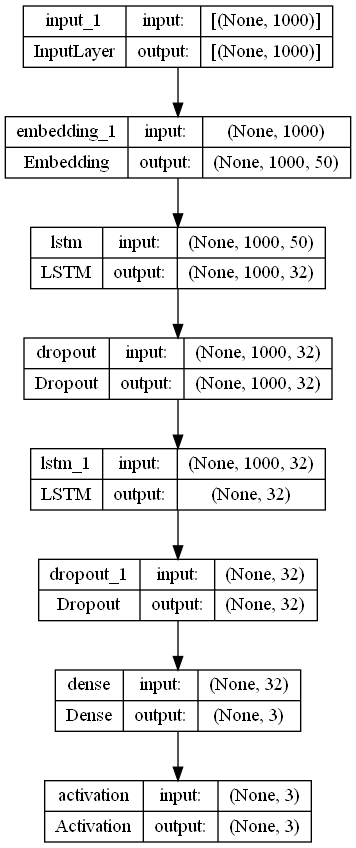

In [28]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)